# Pipeline example

In [19]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MAIN_DATA_DIR = Path.cwd().parent / "data" / "project"
FINAL_DATA_PATH = MAIN_DATA_DIR / "web_logs_merged.parquet"

web_logs = pd.read_parquet(FINAL_DATA_PATH)

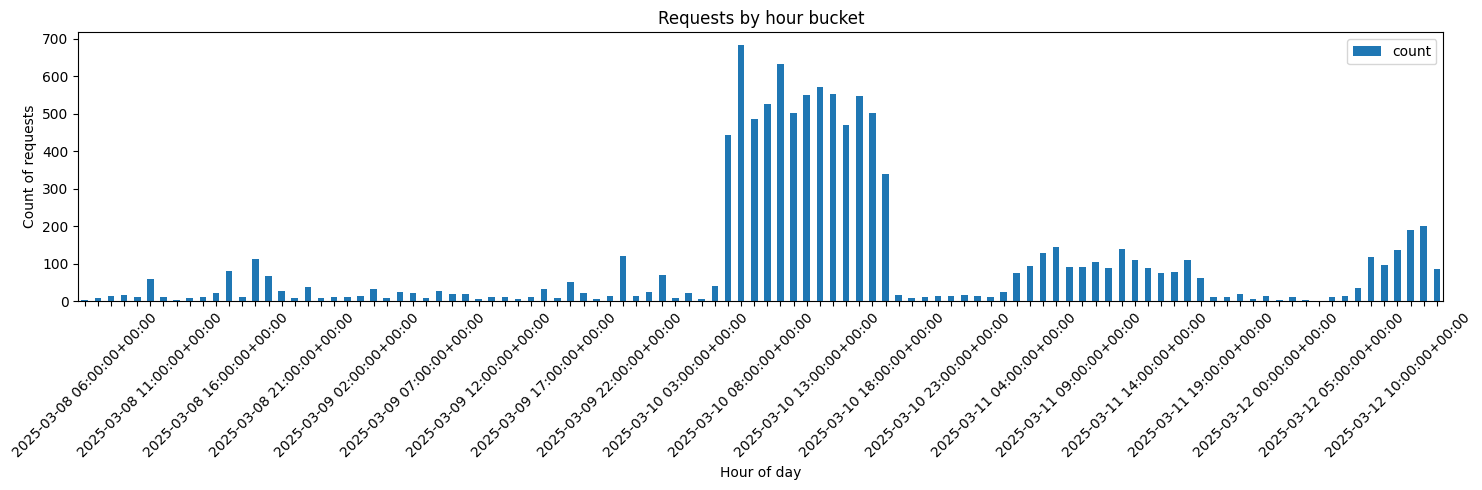

In [20]:
web_logs_temp = web_logs.copy()
# Make count of requests by hour bucket and plot it, multiple days of data
web_logs_temp["hour"] = web_logs_temp["timestamp"].dt.hour
web_logs_temp["day"] = web_logs_temp["timestamp"].dt.date
web_logs_temp["hour_day"] = web_logs_temp["day"].astype(str) + " " + web_logs_temp["hour"].astype(str)
web_logs_temp["hour_day"] = pd.to_datetime(web_logs_temp["hour_day"], format="%Y-%m-%d %H")
web_logs_temp["hour_day"] = web_logs_temp["hour_day"].dt.tz_localize("UTC")
counts = web_logs_temp.groupby("hour_day").size().reset_index(name="count")

# Plotting
ax = counts.plot(x="hour_day", y="count", kind="bar", figsize=(15, 5), title="Requests by hour bucket")

# Customize x-axis labels - show every 5th label
n = 5  # Show every nth label
ticks = ax.xaxis.get_ticklocs()
labels = ax.xaxis.get_ticklabels()
new_ticks = []
new_labels = []
for i, (tick, label) in enumerate(zip(ticks, labels)):
    if i % n == 0:  # Only keep every nth label
        new_ticks.append(tick)
        new_labels.append(label.get_text())
    else:
        new_labels.append("")

ax.set_xticks(ticks)
ax.set_xticklabels(new_labels, rotation=45)

plt.xlabel("Hour of day")
plt.ylabel("Count of requests")
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()


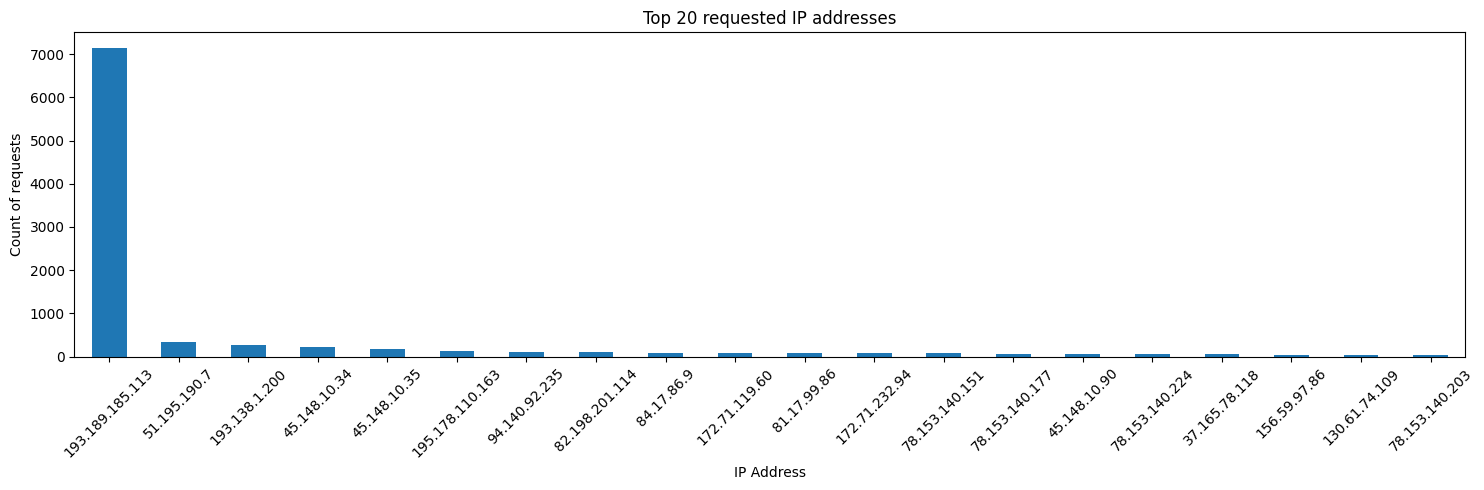

In [25]:
# Make a bar plot for the top 20 requested IP addresses with the count of requests
web_logs["src_ip"].value_counts().head(20).plot(kind="bar", figsize=(15, 5), title="Top 20 requested IP addresses")
plt.xlabel("IP Address")
plt.ylabel("Count of requests")
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

In [51]:
web_logs.pivot_table(index=["country", "company_abuser_level"], values="src_ip", aggfunc="count", observed=True).head(10)

src_ip
country   company_abuser_level        
Australia High                      14
Belgium   High                       2
          Low                        9
          Very High                  7
Bolivia   Elevated                   2
Brazil    Elevated                   1
          Low                        3
Canada    Elevated                   1
          High                      12
          Low                        1

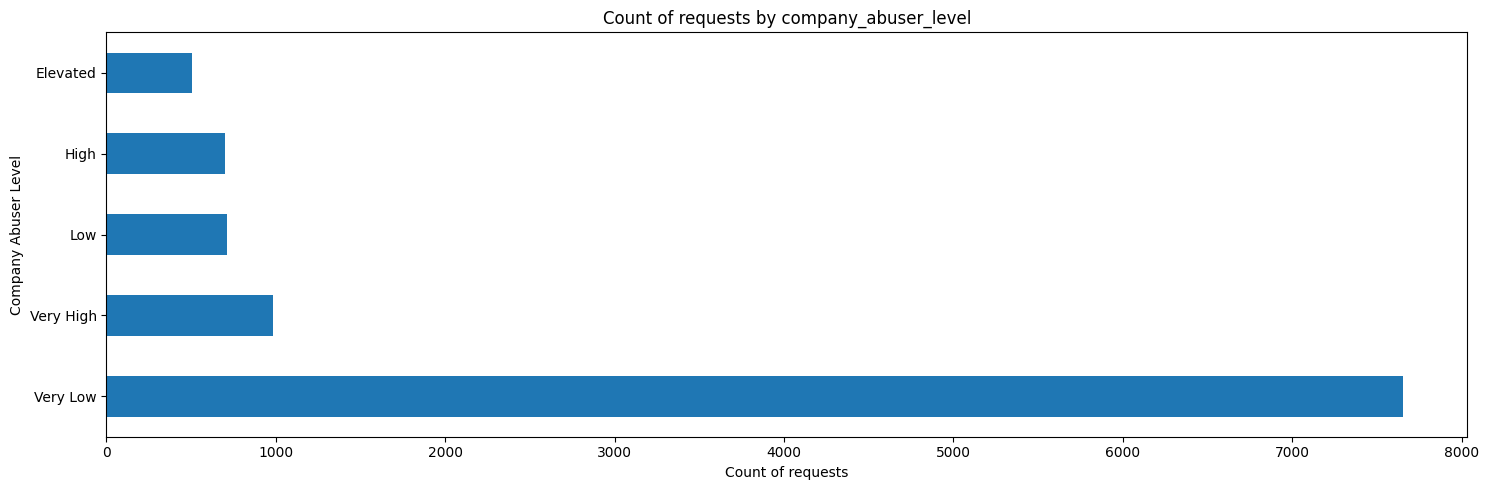

In [52]:
# Make a count plot hbar by company_abuser_level
web_logs["company_abuser_level"].value_counts().plot(kind="barh", figsize=(15, 5), title="Count of requests by company_abuser_level")
plt.xlabel("Count of requests")
plt.ylabel("Company Abuser Level")
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

In [53]:
# Create two datasets,one for real users and one for bots and crawlers
web_logs_temp = web_logs.copy()

# add is_valid_request column to the dataset (if url path starts /api-web/v1/ is valid request)
web_logs_real_users = web_logs_temp[web_logs_temp["company_abuser_level"].isin(["Very Low", "Low"])].copy()
web_logs_bots = web_logs_temp[web_logs_temp["company_abuser_level"].isin(["High", "Very High", "Elevated"])].copy()

## Analyze bots

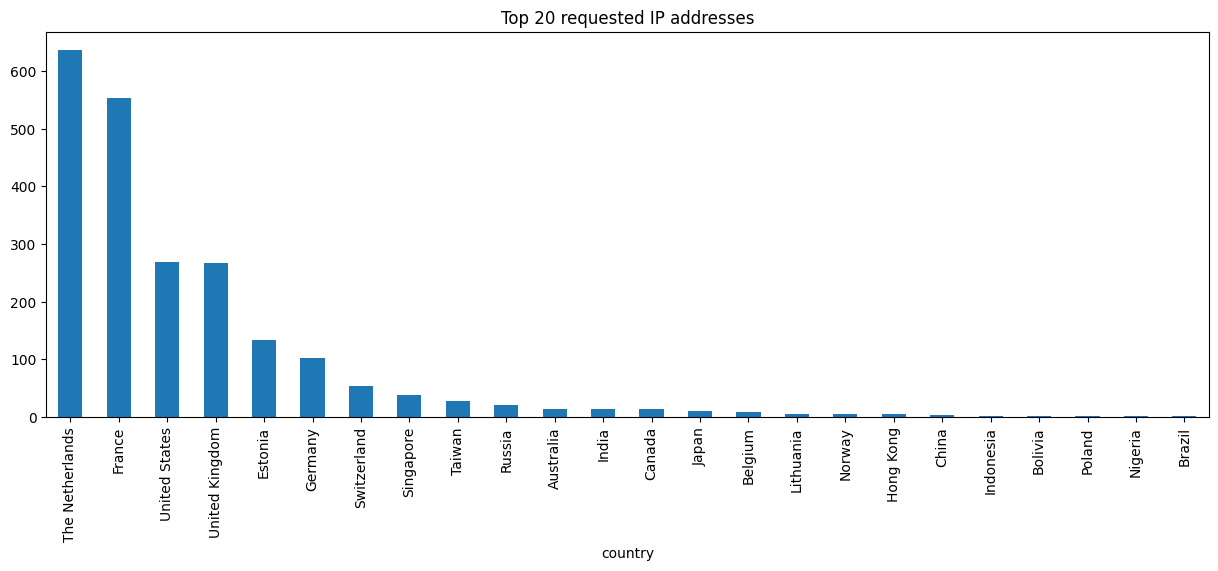

In [54]:
web_logs_bots["country"].value_counts().plot(kind="bar", figsize=(15, 5), title="Top 20 requested IP addresses")
plt.show()

In [35]:
web_logs_bots[web_logs_bots["country"] == "Slovenia"]["http_url_path"].value_counts()

http_url_path
/img/cyber-logo.c24a1e46.svg             24
/img/lower-arrow.7a64c699.png            20
/img/shield-full.1ea8ff61.png            20
/img/upper-arrow.860ee4d0.png            20
/img/night-sky.1701d635.png              20
/img/earth-night-resized.3dce4089.jpg    20
/css/chunk-vendors.77e64f29.css          19
/css/app.96271e32.css                    19
/js/chunk-vendors.f0d1e719.js            18
/js/app.4c07236b.js                      18
/                                        18
/fonts/fa-solid-900.8e1ed89b.woff2       16
/fonts/fa-brands-400.f075c50f.woff2      16
/favicons/favicon.ico                    15
/favicons/site.webmanifest               14
/favicon.ico                              5
/icons/compressed.gif                     4
/fonts/fa-regular-400.4a74738e.woff2      2
/icons/back.gif                           2
/datasets/by_day/                         2
/img/logo-ltfe.67396f0f.png               2
/icons/blank.gif                          2
/js/app.4c07236b.j

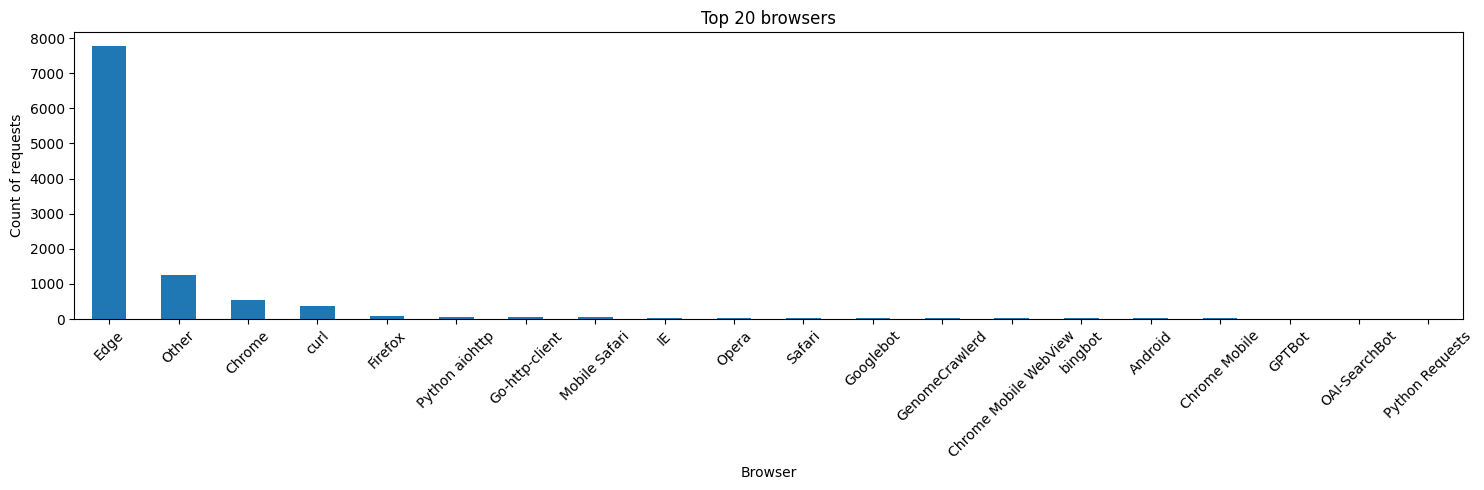

In [55]:
# Check users by browser
web_logs_temp["browser"].value_counts().head(20).plot(kind="bar", figsize=(15, 5), title="Top 20 browsers")
plt.xlabel("Browser")
plt.ylabel("Count of requests")
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

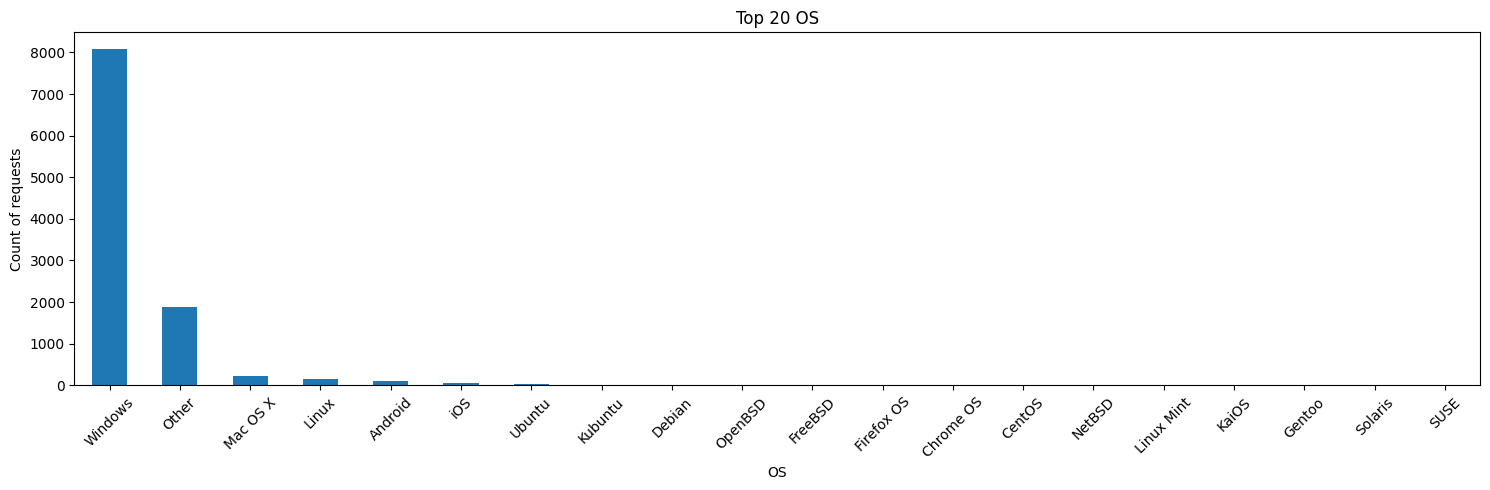

In [56]:
# Check users by OS
web_logs_temp["os"].value_counts().head(20).plot(kind="bar", figsize=(15, 5), title="Top 20 OS")
plt.xlabel("OS")
plt.ylabel("Count of requests")
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

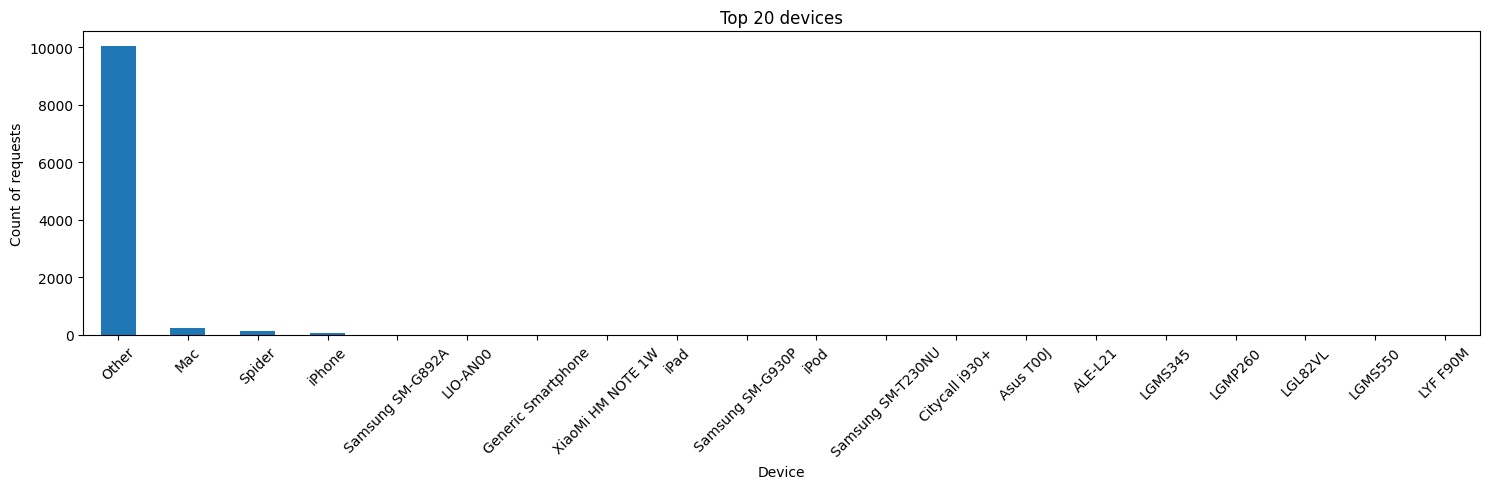

In [57]:
# Check users by device
web_logs_temp["device"].value_counts().head(20).plot(kind="bar", figsize=(15, 5), title="Top 20 devices")
plt.xlabel("Device")
plt.ylabel("Count of requests")
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

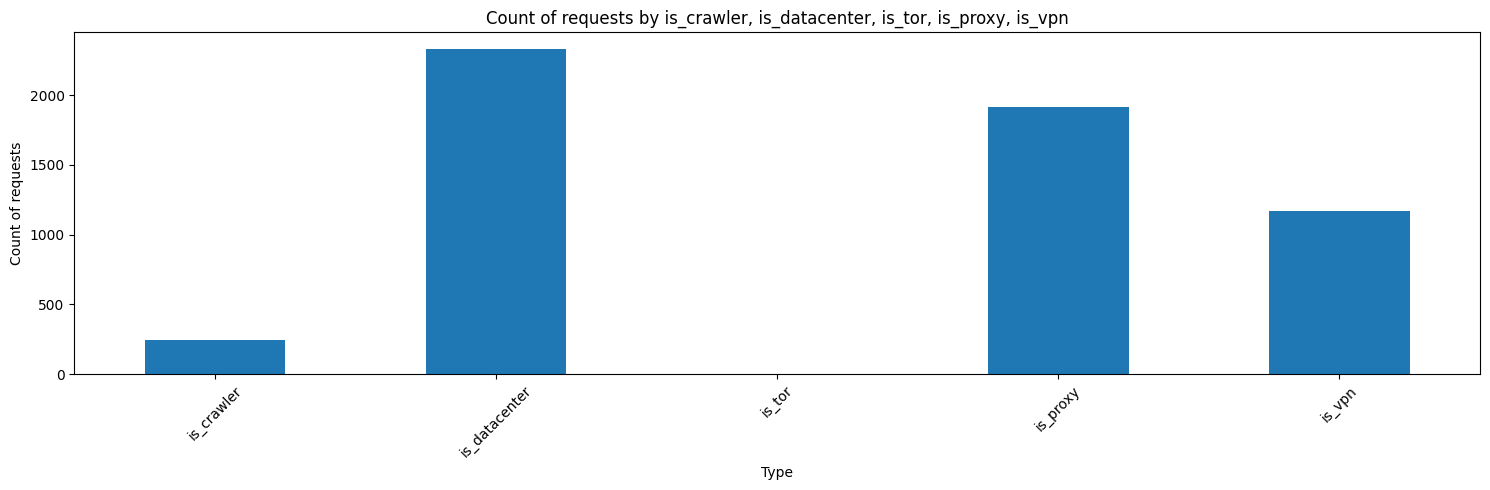

In [ ]:
# Make five count vertical bars plot for is_crawler, is_datacenter, is_tor, is_proxy, is_vpn (in same plot)
web_logs_temp[["is_crawler", "is_datacenter", "is_tor", "is_proxy", "is_vpn"]].sum().plot(
    kind="bar", figsize=(15, 5), title="Count of requests by is_crawler, is_datacenter, is_tor, is_proxy, is_vpn"
)
plt.xlabel("Type")
plt.ylabel("Count of requests")
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

## Task: Extract unique users of the webpage

In [93]:
web_logs_temp = web_logs.copy()
print(f"--> [STEP: 0] Total requests: {web_logs_temp.shape[0]}, total unique IPs: {web_logs_temp['src_ip'].nunique()}")
# remove all requests with status code not 200
web_logs_temp = web_logs_temp[web_logs_temp["http_status_code"] == 200]
print(f"--> [STEP: 1] Total requests: {web_logs_temp.shape[0]}, total unique IPs: {web_logs_temp['src_ip'].nunique()}")
# remove is_crawler requests
web_logs_temp = web_logs_temp[web_logs_temp["is_crawler"] == False]
print(f"--> [STEP: 2] Total requests: {web_logs_temp.shape[0]}, total unique IPs: {web_logs_temp['src_ip'].nunique()}")
# remove 193.189.185.113 requests (this is a bot that is not detected as a crawler)
web_logs_temp = web_logs_temp[web_logs_temp["src_ip"] != "193.189.185.113"]
print(f"--> [STEP: 3] Total requests: {web_logs_temp.shape[0]}, total unique IPs: {web_logs_temp['src_ip'].nunique()}")
# remove is_datacenter requests
web_logs_temp = web_logs_temp[web_logs_temp["is_datacenter"] == False]
print(f"--> [STEP: 4] Total requests: {web_logs_temp.shape[0]}, total unique IPs: {web_logs_temp['src_ip'].nunique()}")
# remove is_abuser == True requests
web_logs_temp = web_logs_temp[web_logs_temp["is_abuser"] == False]
print(f"--> [STEP: 5] Total requests: {web_logs_temp.shape[0]}, total unique IPs: {web_logs_temp['src_ip'].nunique()}")
# remove requests for /robots.txt
web_logs_temp = web_logs_temp[web_logs_temp["http_url_path"] != "/robots.txt"]
print(f"--> [STEP: 6] Total requests: {web_logs_temp.shape[0]}, total unique IPs: {web_logs_temp['src_ip'].nunique()}")
# remove all ips with less than 10 requests
web_logs_temp = web_logs_temp[web_logs_temp["src_ip"].map(web_logs_temp["src_ip"].value_counts()) >= 10]
print(f"--> [STEP: 7] Total requests: {web_logs_temp.shape[0]}, total unique IPs: {web_logs_temp['src_ip'].nunique()}")

--> [STEP: 0] Total requests: 10552, total unique IPs: 476
--> [STEP: 1] Total requests: 8320, total unique IPs: 159
--> [STEP: 2] Total requests: 8256, total unique IPs: 139
--> [STEP: 3] Total requests: 1117, total unique IPs: 138
--> [STEP: 4] Total requests: 747, total unique IPs: 18
--> [STEP: 5] Total requests: 732, total unique IPs: 13
--> [STEP: 6] Total requests: 730, total unique IPs: 11
--> [STEP: 7] Total requests: 725, total unique IPs: 9


In [94]:
web_logs_temp.value_counts("country")

country
Slovenia    444
Germany     105
Turkey       89
France       52
Egypt        35
Name: count, dtype: int64

In [95]:
web_logs_temp.value_counts("company_name")

company_name
Institut Jozef Stefan                                267
Telemach d.o.o.                                      114
Bremen Briteline GmbH                                105
TELNET TELEKOM HIZMETLERI ANONIM SIRKETI              89
Free Mobile SAS                                       52
TE Data                                               35
A1 Slovenija telekomunikacijske storitve,d.d.         26
Telekom Slovenije, d.d.                               19
Telekom Slovenije d.d. 1000 Ljubljana SI Slovenia     18
Name: count, dtype: int64

C:\Users\leon1\AppData\Local\Temp\ipykernel_18876\2630975111.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time = counts['hour_day'].min().floor('H')  # Round down to nearest hour
C:\Users\leon1\AppData\Local\Temp\ipykernel_18876\2630975111.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end_time = counts['hour_day'].max().ceil('H')     # Round up to nearest hour
C:\Users\leon1\AppData\Local\Temp\ipykernel_18876\2630975111.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=start_time, end=end_time, freq='H', tz='UTC')


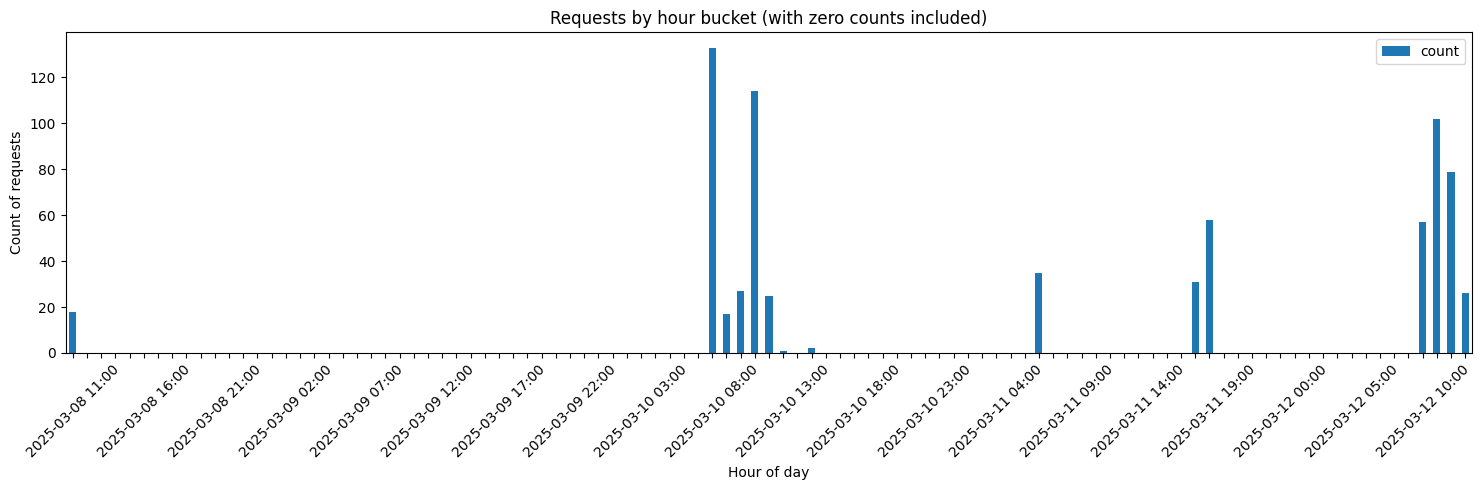

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create hour buckets from your data
web_logs_temp["hour"] = web_logs_temp["timestamp"].dt.hour
web_logs_temp["day"] = web_logs_temp["timestamp"].dt.date
web_logs_temp["hour_day"] = web_logs_temp["day"].astype(str) + " " + web_logs_temp["hour"].astype(str)
web_logs_temp["hour_day"] = pd.to_datetime(web_logs_temp["hour_day"], format="%Y-%m-%d %H")
web_logs_temp["hour_day"] = web_logs_temp["hour_day"].dt.tz_localize("UTC")

# Get counts by hour
counts = web_logs_temp.groupby("hour_day").size().reset_index(name="count")

# Create complete datetime range covering all hours in your data period
start_time = counts["hour_day"].min().floor("H")  # Round down to nearest hour
end_time = counts["hour_day"].max().ceil("H")  # Round up to nearest hour
full_range = pd.date_range(start=start_time, end=end_time, freq="H", tz="UTC")

# Create DataFrame with complete range and merge with counts
full_df = pd.DataFrame({"hour_day": full_range})
counts_complete = full_df.merge(counts, on="hour_day", how="left").fillna(0)

# Plotting
ax = counts_complete.plot(x="hour_day", y="count", kind="bar", figsize=(15, 5), title="Requests by hour bucket (with zero counts included)")

# Customize x-axis labels - show every 5th label
n = 5  # Show every nth label
ticks = ax.xaxis.get_ticklocs()
labels = [pd.to_datetime(label.get_text()).strftime("%Y-%m-%d %H:%M") if label.get_text() else "" for label in ax.xaxis.get_ticklabels()]

new_labels = [label if i % n == 0 else "" for i, label in enumerate(labels)]
ax.set_xticks(ticks)
ax.set_xticklabels(new_labels, rotation=45)

plt.xlabel("Hour of day")
plt.ylabel("Count of requests")
plt.tight_layout()
plt.show()

In [104]:
french_user = web_logs_temp[web_logs_temp["country"] == "France"]
start_time = french_user["timestamp"].min()
end_time = french_user["timestamp"].max()
session_duration = (end_time - start_time).total_seconds()
print("Session duration in seconds: ", session_duration / 60)

Session duration in seconds:  28.55


C:\Users\leon1\AppData\Local\Temp\ipykernel_18876\1621287098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  french_user["minute"] = french_user["timestamp"].dt.minute


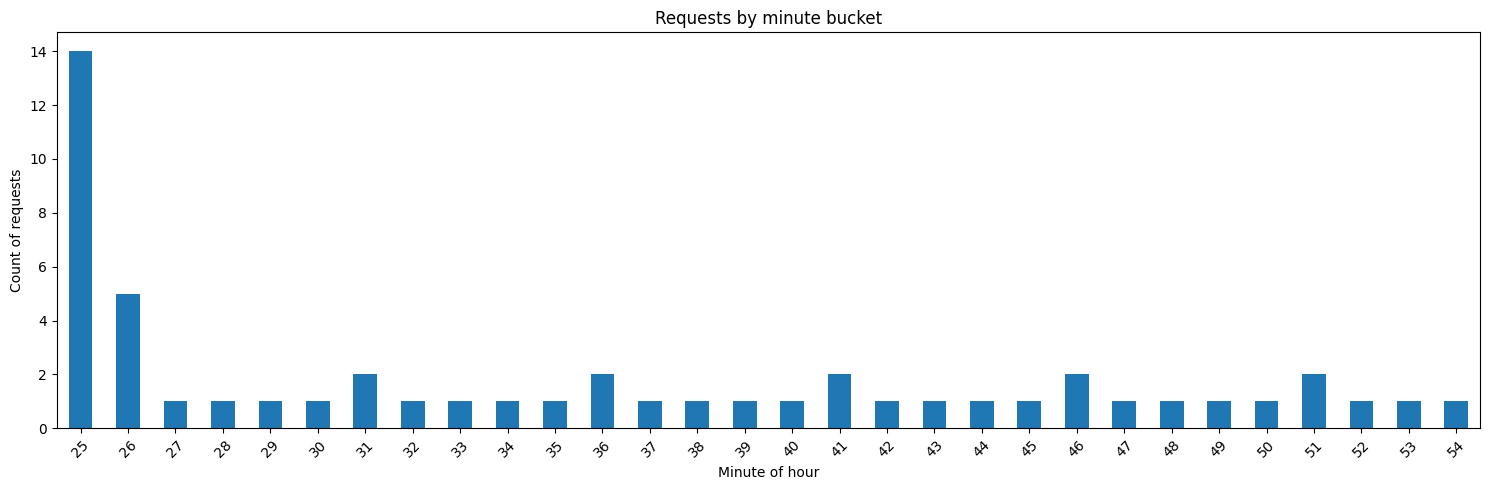

In [ ]:
# plot requests by minute buctets
french_user["minute"] = french_user["timestamp"].dt.minute

french_user.groupby("minute").size().plot(kind="bar", figsize=(15, 5), title="Requests by minute bucket")
plt.xlabel("Minute of hour")
plt.ylabel("Count of requests")
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()


In [111]:
# print browser and device for the french user
print(french_user[["browser", "device"]].head(10))

     browser device
3098  Chrome  Other
3099  Chrome  Other
3100  Chrome  Other
3101  Chrome  Other
3102  Chrome  Other
3104  Chrome  Other
3105  Chrome  Other
3106  Chrome  Other
3107  Chrome  Other
3108  Chrome  Other
